## Task 6.5. Unsupervised Machine Learning

### This script contains the following:
#### 1. Importing libraries and data
#### 2. Data cleaning and preparation
##### 2.1. Standardization
#### 3. The "Elbow Technique"
#### 4. Number of clusters
#### 5. k-means algorithm
#### 6. Adding a clusters column
#### 7. Visualizations 
#### 8. Conclusions
#### 9. Descriptive statistics
#### 10. Next steps 

##     -------------------------------------------------------------------------------------------------------------------------

### 1. Importing libraries and data

In [1]:
# To import the libraries we will need for this exercise

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.cluster import KMeans # Here is where you import the k-means algorithm from scikit-learn.
import pylab as pl # PyLab is a convenience module that bulk imports matplotlib.

In [2]:
# This option ensures the graphs you create are displayed in your notebook without the need to "call" them specifically.

%matplotlib inline

In [3]:
# Then we create a path 

path = r'C:\Users\javis\OneDrive\Documentos\Career Foundry\2. Data Immersion\6. Advanced Analytics\UK HPI Project'

In [4]:
# We import our data, which had already been wrangled

df = pd.read_csv(os.path.join(path,'2. Data', '2.2. Prepared Data', 'HPI wrangled.csv'), index_col = False)

In [5]:
# To have another look at how it looks like

df.head()

,Unnamed: 0,Date,RegionName,AreaCode,AveragePrice,Index,IndexSA,%Change_AvgPrice_1month,%Change_AvgPrice_12months,AveragePriceSA,...,NewPrice,NewIndex,New1m%Change,New12m%Change,NewSalesVolume,OldPrice,OldIndex,Old1m%Change,Old12m%Change,OldSalesVolume
0,0,01/01/2004,Aberdeenshire,S12000034,81693.66964,40.864214,NaN,NaN,NaN,NaN,...,88436.13953,40.267250,NaN,NaN,103.0,81043.95084,40.883367,NaN,NaN,285.0
1,1,01/02/2004,Aberdeenshire,S12000034,81678.76231,40.856757,NaN,-0.018248,NaN,NaN,...,88606.44649,40.344795,0.192576,NaN,107.0,80965.29542,40.843688,-0.097053,NaN,219.0
2,2,01/03/2004,Aberdeenshire,S12000034,83525.09702,41.780317,NaN,2.260483,NaN,NaN,...,90296.91375,41.114508,1.907838,NaN,140.0,82903.23948,41.821302,2.393549,NaN,313.0
3,3,01/04/2004,Aberdeenshire,S12000034,84333.67900,42.184780,NaN,0.968071,NaN,NaN,...,90319.87844,41.124964,0.025432,NaN,180.0,84003.99161,42.376586,1.327755,NaN,391.0
4,4,01/05/2004,Aberdeenshire,S12000034,86379.95396,43.208353,NaN,2.426403,NaN,NaN,...,91989.17763,41.885039,1.848208,NaN,167.0,86222.73484,43.495852,2.641235,NaN,335.0


### 2. Data cleaning and preparation

In [6]:
# Firstly I will check missing values

df.isnull().sum()

Unnamed: 0                        0
Date                              0
RegionName                        0
AreaCode                          0
AveragePrice                      0
Index                             0
IndexSA                      130305
%Change_AvgPrice_1month         443
%Change_AvgPrice_12months      5040
AveragePriceSA               130305
SalesVolume                    4499
DetachedPrice                  6237
DetachedIndex                  6237
Detached1m%Change              6646
Detached12m%Change            11121
SemiDetachedPrice              6225
SemiDetachedIndex              6225
SemiDetached1m%Change          6634
SemiDetached12m%Change        11109
TerracedPrice                  6198
TerracedIndex                  6198
Terraced1m%Change              6607
Terraced12m%Change            11082
FlatPrice                      5901
FlatIndex                      5901
Flat1m%Change                  6311
Flat12m%Change                10797
CashPrice                   

In [7]:
# There are still many data columns with Nan Values. For the purpose of this exercise, I will create a subset with 
# the variables that we use the most. I will define the columns first, ensuring they are numerical.

columns = ["AveragePrice","SalesVolume","Index","%Change_AvgPrice_1month","%Change_AvgPrice_12months", "NewPrice","NewSalesVolume", "OldPrice", "OldSalesVolume"]

In [8]:
# To create the subset

df_sub = df[columns]

In [9]:
# For those variables that we will use with nan values, I will impute missing values with median

df_sub['%Change_AvgPrice_1month'].fillna(df_sub['%Change_AvgPrice_1month'].median(), inplace=True)
df_sub['%Change_AvgPrice_12months'].fillna(df_sub['%Change_AvgPrice_12months'].median(), inplace=True)
df_sub['NewPrice'].fillna(df_sub['NewPrice'].median(), inplace=True)
df_sub['NewSalesVolume'].fillna(df_sub['NewSalesVolume'].median(), inplace=True)
df_sub['OldPrice'].fillna(df_sub['OldPrice'].median(), inplace=True)
df_sub['OldSalesVolume'].fillna(df_sub['OldSalesVolume'].median(), inplace=True)
df_sub['SalesVolume'].fillna(df_sub['SalesVolume'].median(), inplace=True)

C:\Users\javis\OneDrive\Documentos\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [10]:
# Let's double check missing values have been imputed

df_sub.isnull().sum()

AveragePrice                 0
SalesVolume                  0
Index                        0
%Change_AvgPrice_1month      0
%Change_AvgPrice_12months    0
NewPrice                     0
NewSalesVolume               0
OldPrice                     0
OldSalesVolume               0
dtype: int64

#### 2.1. Standardization

In [11]:
# To ensure our data is suitable for the k-means analysis, we will standardize our variables
# Firstly, we have to import the StandardScaler module and the PCA (Principal Components Analysis)

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [12]:
# We then standardize our data

scaler = StandardScaler()
df_sub_std = scaler.fit_transform (df_sub)

In [13]:
# After, we have to perform dimensionality reduction with PCA. It has 3 steps:
# First, we must fit our standardized data using PCA

pca = PCA()
pca.fit(df_sub_std)

PCA()

In [14]:
# Second, we need to decide how many features we’d like to keep based on the cumulative variance plot.

pca.explained_variance_ratio_

array([3.67247720e-01, 3.26498848e-01, 1.55561743e-01, 7.13007036e-02,
       6.21841681e-02, 8.11793233e-03, 6.67153931e-03, 2.22759308e-03,
       1.89752404e-04])

Text(0, 0.5, 'Cumulative explained variance')

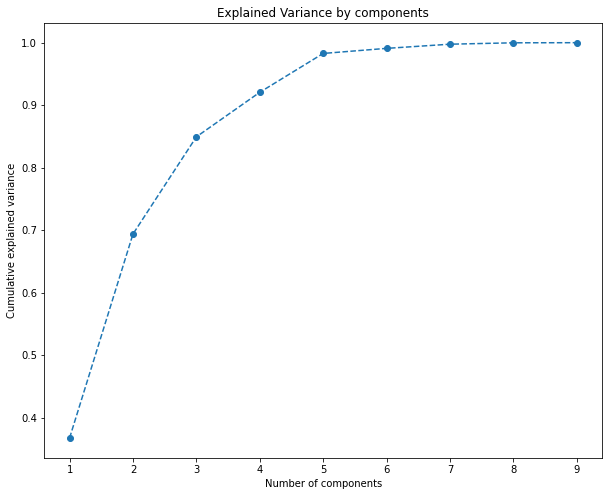

In [15]:
plt.figure(figsize = (10, 8))
plt.plot (range(1,10), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title ('Explained Variance by components')
plt.xlabel ('Number of components')
plt.ylabel ('Cumulative explained variance')

A rule of thumb is to preserve around 80 % of the variance. Because of this, we will keep 3 principal components.

In [16]:
# The third step is to perform PCA with the chosen number of components kept.
# To choose the number of components

pca = PCA (n_components = 3)

In [17]:
# Now we fit the model into our data with the selected number of components, 3 in this case.

pca.fit (df_sub_std)

PCA(n_components=3)

In [18]:
# We need only the calculated resulting components scores for the elements in our data set:

pca.transform(df_sub_std)

array([[-1.74355892, -0.15467567, -0.23525166],
       [-1.72405228, -0.16401873, -0.42599505],
       [-1.76783759, -0.11512431,  0.3678255 ],
       ...,
       [ 1.2795527 ,  0.16427758, -1.40137468],
       [ 0.55915279, -0.20515692,  0.47866835],
       [ 0.59660379, -0.20398813,  0.48678595]])

In [19]:
# Now we create the scores that we will introduce in the k-means.

scores_pca = pca.transform (df_sub_std)

### 3. The "Elbow Technique"

In [20]:
# Firstly, we define the range of potential clusters for our set. In this case, I choose 10 as a maximum. 

num_cl = range(1, 10) # This defines the range of potential clusters in the data.
kmeans = [KMeans(n_clusters=i) for i in num_cl] # This defines k-means clusters in the range assigned above.

In [21]:
score = [kmeans[i].fit(df_sub_std).score(df_sub_std) for i in range(len(kmeans))]

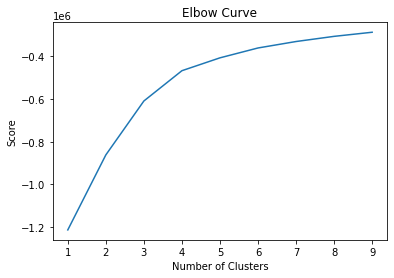

In [22]:
# We'll now plot the elbow curve by using PyLab.

pl.plot(num_cl,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

### 4. Number of clusters 

The optimal count for our clusters given this graphic would be 4. I chose this because from 4 onwards the line is straightening, and adding more clusters wouldn't help to better explain the variances.

### 5. k-means algorithm

In [23]:
# Firstly we create the k-means object.

kmeans = KMeans(n_clusters = 4, n_jobs = -1) 

In [24]:
# To fit the k-means object to the data.

kmeans.fit(df_sub_std)

C:\Users\javis\OneDrive\Documentos\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=4, n_jobs=-1)

### 6. Adding a clusters column 

In [25]:
# We create a column in our dataframe in order to make a visualization later

df_sub['clusters'] = kmeans.fit_predict(df_sub_std)

C:\Users\javis\OneDrive\Documentos\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
<ipython-input-25-5002816409d9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['clusters'] = kmeans.fit_predict(df_sub_std)


In [26]:
# Let's have a look at our new column

df_sub.head()

,AveragePrice,SalesVolume,Index,%Change_AvgPrice_1month,%Change_AvgPrice_12months,NewPrice,NewSalesVolume,OldPrice,OldSalesVolume,clusters
0,81693.66964,388.0,40.864214,0.530798,5.535979,88436.13953,103.0,81043.95084,285.0,1
1,81678.76231,326.0,40.856757,-0.018248,5.535979,88606.44649,107.0,80965.29542,219.0,1
2,83525.09702,453.0,41.780317,2.260483,5.535979,90296.91375,140.0,82903.23948,313.0,1
3,84333.67900,571.0,42.184780,0.968071,5.535979,90319.87844,180.0,84003.99161,391.0,1
4,86379.95396,502.0,43.208353,2.426403,5.535979,91989.17763,167.0,86222.73484,335.0,1


In [27]:
# To see how many observations there are in each cluster

df_sub['clusters'].value_counts()

3    72747
1    46700
0    14376
2     1006
Name: clusters, dtype: int64

### 7. Visualizations

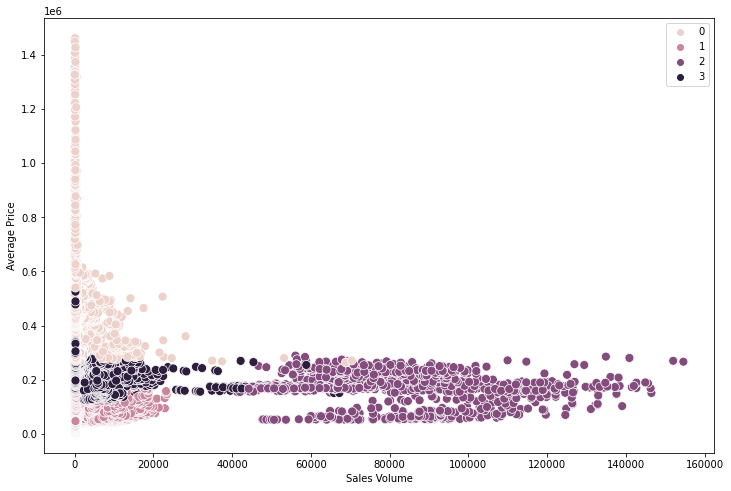

In [28]:
# Let's initially plot the clusters for "AveragePrice" and "SalesVolume". 
# 'Hue' will take the result of running the k=means algorithm, 's' defines the size of the points in the plot

plt.figure(figsize=(12,8))
ax_sales_price = sns.scatterplot(x=df_sub['SalesVolume'], y=df_sub['AveragePrice'], hue=kmeans.labels_, s=80) 
ax_sales_price.grid(False) # This removes the grid from the background.
plt.xlabel('Sales Volume') # Label x-axis.
plt.ylabel('Average Price') # Label y-axis.
plt.show()

In [29]:
# To export the plot

ax_sales_price.figure.savefig(os.path.join(path, '4. Analysis', 'sales_avg_price_scatterplot.png'))

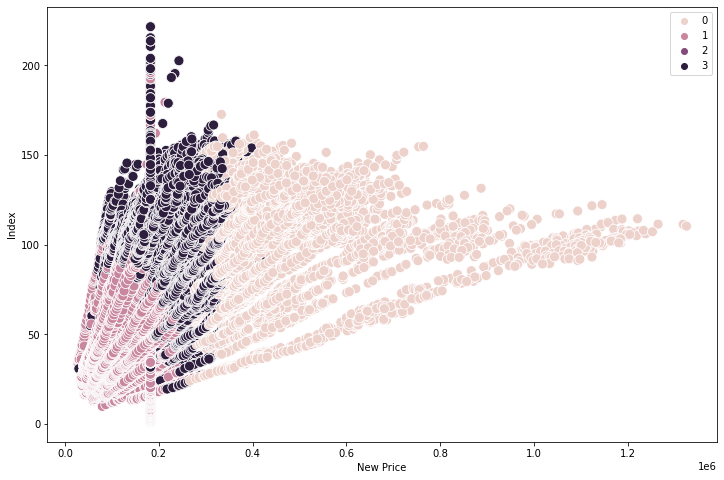

In [30]:
# Let's also plot the clusters for the "Index" and "NewPrice" variables.

plt.figure(figsize=(12,8))
ax_new_price_index = sns.scatterplot(x=df_sub['NewPrice'], y=df_sub['Index'], hue=kmeans.labels_, s=100)

ax_new_price_index.grid(False) 
plt.xlabel('New Price') 
plt.ylabel('Index') 
plt.show()

The index in our dataframe measures average price changes in repeat sales or refinancing on a specific number of properties.
NewPrice would represent the average price of the sold new houses in the UK for each specific period.

In [31]:
# To export the plot

ax_new_price_index.figure.savefig(os.path.join(path, '4. Analysis', 'new_price_index_scatterplot.png'))

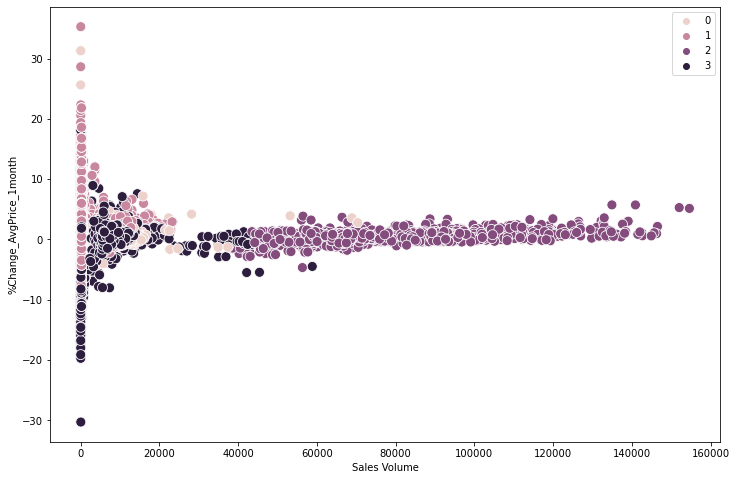

In [32]:
# Let's also plot the clusters for the "SalesVolume" and "%Change_AvgPrice_1month" variables.

plt.figure(figsize=(12,8))
ax_sales_change_1m = sns.scatterplot(x=df_sub['SalesVolume'], y=df_sub['%Change_AvgPrice_1month'], hue=kmeans.labels_, s=100)

ax_sales_change_1m.grid(False) 
plt.xlabel('Sales Volume') 
plt.ylabel('%Change_AvgPrice_1month') 
plt.show()

In [33]:
# To export the plot

ax_sales_change_1m.figure.savefig(os.path.join(path, '4. Analysis', 'sales_change_1month_scatterplot.png'))

The %Change_AvgPrice_1month variable represents the variation, in percentage, of the sold houses' average price in a specific month respect the month before.
The %Change_AvgPrice_12month variable represents the variation, in percentage, of the sold houses' average price in a specific month respect the same month on previous year. 

### 8. Conclusions

- On the Sales Volume vs Average Price graph, the clusters make sense as there seem to be 3 groups for the different average prices when the sales have been between 0-200K, and one final group for those months with more than 200K sales. Still there are some points that seem out of place.

- On the Index vs New Price plot, it would have made more sense to do 3 clusters as you can't really appreciate the purple dots. For this particular relationship maybe 3 would have been more suitable.

- On the %Change_AvgPrice_1month vs Sales Volume plot it's not to clear which pattern the dark pink color is following, or the pertenence to a different group to many points close to them. The location suggests that 3 clusters would have been enough.

### 9. Descriptive Statistics

In [40]:
# Firstly we are going to give the colors names to the group for a visual call

df_sub.loc[df_sub['clusters'] == 1, 'cluster'] = 'cream'
df_sub.loc[df_sub['clusters'] == 0, 'cluster'] = 'pink'
df_sub.loc[df_sub['clusters'] == 2, 'cluster'] = 'purple'
df_sub.loc[df_sub['clusters'] == 3, 'cluster'] = 'black'

C:\Users\javis\OneDrive\Documentos\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\javis\OneDrive\Documentos\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\javis\OneDrive\Documentos\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set 

In [41]:
df_sub.groupby('cluster').agg({'AveragePrice':['mean', 'median'], 
                         'SalesVolume':['mean', 'median'], 
                         'Index':['mean', 'median'],
                          '%Change_AvgPrice_1month':['mean', 'median']})

AveragePrice                 SalesVolume                Index  \
                  mean        median          mean   median        mean   
cluster                                                                   
black    176071.775756  170140.72580    543.938934    198.0   99.085414   
cream    396343.903186  357539.28300    541.750472    197.0  110.067573   
pink      79583.377604   69337.99359    632.141741    235.0   41.820273   
purple   170975.247325  176095.09230  82024.746521  79652.5   86.873966   

                    %Change_AvgPrice_1month            
             median                    mean    median  
cluster                                                
black     97.880705                0.194984  0.291246  
cream    116.881408                0.514171  0.495985  
pink      36.764663                1.188586  1.011172  
purple    89.228213                0.505043  0.457946

The mean and median of the purple sales volume, compared to the other 3 clusters, is very large. This could indicate that these data points are the ones relating to regions. This, added to the previous finding of cluster 2 (purple) having just over 1000 observations, seems a clear indicator of this group relating to regions, so their value is the addition of the individual counties values. 

### 10. Next steps

We should confirm that purple group relates to the regions and focus our analysis on this group to understand the differences in the house selling market prices of the different areas.

We should now make a time series analysis, to see how sales have evolved in time, and if they have done it in the same way in every region. Also to see the connection between prices and indexes, or spot patterns between houses bought by cash or with mortgage over time, seeking for new insights.

It would be interesting to see one chorpleth map for each of the clusters, to analyse the behaviour of the different groups by areas and stablish possible patterns that scape from previous geographic analysis.